In [47]:
from pomegranate import *
import matplotlib.pyplot as plot
import re

In [105]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    sl = None
    pl = None
    il = None
    
    a = []
    b = []
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        m = re.search('([MDIR]+)(\d+)', name)
        s = m.group(1)
        p = int(m.group(2))

        if s == 'RD':
            if sl == 'M' or sl == 'I' or sl == 'D':
                a.append(x[pl:(p-1)])
                b.append((p-pl-1)*'~')
        elif s == 'RI':
            if sl == 'M' or sl == 'I' or sl == 'D':
                a.append((p-pl-1)*'~')
                b.append(y[il:(i-1)])
        elif s == 'M' or s == 'I' or s == 'D':
            if sl == 'RI':
                a.append((p-pl-1)*'~')
                b.append(y[il:(i-1)])
            elif sl == 'RD':
                a.append(x[pl:(p-1)])
                b.append((p-pl-1)*'~')

            if s == 'M':
                a.append(x[p-1])
                b.append(y[i-1])
            elif s == 'I':
                a.append('-')
                b.append(y[i-1])
            elif s == 'D':
                a.append(x[p-1])
                b.append('-')
            
        sl = s
        pl = p
        il = i

    return ''.join(a), ''.join(b)

In [38]:
def make_model(target):
    model = HiddenMarkovModel()
    s = {}
    
    # add states
    rib = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name="RI0")
    rdb = State(None, name="RD0")
    
    mb = State(DiscreteDistribution({
        "A": 0.94 if target[0] == 'A' else 0.02,
        "C": 0.94 if target[0] == 'C' else 0.02,
        "G": 0.94 if target[0] == 'G' else 0.02,
        "T": 0.94 if target[0] == 'T' else 0.02,
    }), name="M0")    
    ib = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name="I0")
    
    model.add_states([rib, rdb, mb, ib])
    
    s[rib.name] = rib
    s[rdb.name] = rdb
    s[mb.name]  = mb
    s[ib.name]  = ib
    
    for c in range(len(target) - 1):
        dc = State(None, name=f"D{c+1}")
        
        mc = State(DiscreteDistribution({
            "A": 0.94 if target[c] == 'A' else 0.02,
            "C": 0.94 if target[c] == 'C' else 0.02,
            "G": 0.94 if target[c] == 'G' else 0.02,
            "T": 0.94 if target[c] == 'T' else 0.02,
        }), name=f"M{c+1}")
        
        ic = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"I{c+1}")

        model.add_states([mc, ic, dc])
        
        s[dc.name] = dc
        s[mc.name] = mc
        s[ic.name] = ic
        
    me = State(DiscreteDistribution({
        "A": 0.94 if target[len(target)-1] == 'A' else 0.02,
        "C": 0.94 if target[len(target)-1] == 'C' else 0.02,
        "G": 0.94 if target[len(target)-1] == 'G' else 0.02,
        "T": 0.94 if target[len(target)-1] == 'T' else 0.02,
    }), name=f"M{len(target)}")
        
    rie = State(DiscreteDistribution({ 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }), name=f"RI{len(target)}")
    rde = State(None, name=f"RD{len(target)}")
    
    s[me.name] = me
    s[rie.name] = rie
    s[rde.name] = rde

    # add transitions
    model.add_transition(model.start, s['RD0'], 0.5)
    model.add_transition(model.start, s['RI0'], 0.5)
    
    model.add_transition(s['RI0'], s['RI0'], 0.5)
    model.add_transition(s['RI0'], s['RD0'], 0.5)
    
    for c in range(len(target)):
        model.add_transition(s['RD0'], s[f'M{c}'], 1.0/len(target))
        
    model.add_transition(s['M0'], s['I0'], 0.05)
    model.add_transition(s['M0'], s['D1'], 0.05)
    model.add_transition(s['M0'], s['M1'], 0.85)
    model.add_transition(s['M0'], s[f'RD{len(target)}'], 0.05)

    model.add_transition(s['I0'], s['D1'], 0.15)
    model.add_transition(s['I0'], s['I0'], 0.15)
    model.add_transition(s['I0'], s['M1'], 0.70)
    
    for c in range(1, len(target)-1):
        model.add_transition(s[f'D{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'D{c}'], s[f'I{c}'],   0.70)
        model.add_transition(s[f'D{c}'], s[f'M{c+1}'], 0.15)
        
        model.add_transition(s[f'I{c}'], s[f'D{c+1}'], 0.15)
        model.add_transition(s[f'I{c}'], s[f'I{c}'],   0.15)
        model.add_transition(s[f'I{c}'], s[f'M{c+1}'], 0.70)

        model.add_transition(s[f'M{c}'], s[f'D{c+1}'], 0.05)
        model.add_transition(s[f'M{c}'], s[f'I{c}'],   0.05)
        model.add_transition(s[f'M{c}'], s[f'M{c+1}'], 0.85)
        model.add_transition(s[f'M{c}'], s[f'RD{len(target)}'], 0.05)

    model.add_transition(s[f'M{len(target)}'], s[f'RD{len(target)}'], 0.05)
        
    model.add_transition(s[f'RD{len(target)}'], model.end, 0.5)
    model.add_transition(s[f'RD{len(target)}'], s[f'RI{len(target)}'], 0.5)
    
    model.add_transition(s[f'RI{len(target)}'], s[f'RI{len(target)}'], 0.5)
    model.add_transition(s[f'RI{len(target)}'], model.end, 0.5)
    
    model.bake()
    
    return model

In [43]:
target = "CGTACTTATCGATCG"

model = make_model(target)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Install pygraphviz for nicer visualizations
  """


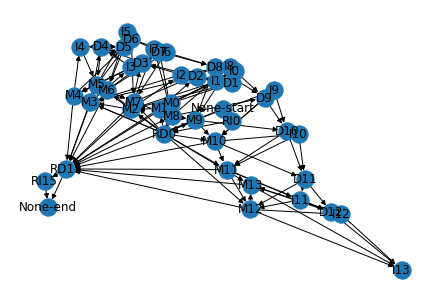

In [44]:
l = {}
for s in model.states:
    l[s] = s.name

model.plot(labels=l)

In [106]:
for sequence in map(list, ('CGTACTTATCGATCG', 'CTTATCG', 'CCAGATACGTACTTATCGATCGGGGATAC')):
    logp, path = model.viterbi(sequence)
    x, y = path_to_alignment(target, ''.join(sequence), path)
    
    print(f"Sequence: {''.join(sequence)}, Log Probability: {logp}")
    print(f"{x}\n{y}")
    print(" ".join( state.name for idx, state in path[1:-1] ))
    print("")

Sequence: CGTACTTATCGATCG, Log Probability: -11.631989353391774
CGTACTTATCGATC
CGTACTTATCGAT~
RD0 M1 M2 M3 M4 M5 M6 M7 M8 M9 M10 M11 M12 M13 RD15 RI15 RI15

Sequence: CTTATCG, Log Probability: -8.429325363730973
CGTACTTATCGATC
~~~~CTTATCG~~~
RD0 M5 M6 M7 M8 M9 M10 M11 RD15

Sequence: CCAGATACGTACTTATCGATCGGGGATAC, Log Probability: -40.74417093690946
CGTACTTATCGATC
CGTACTTATCGAT~
RI0 RI0 RI0 RI0 RI0 RI0 RI0 RD0 M1 M2 M3 M4 M5 M6 M7 M8 M9 M10 M11 M12 M13 RD15 RI15 RI15 RI15 RI15 RI15 RI15 RI15 RI15 RI15

